In [2]:
# %pip install numpy scikit-learn

### Vectorización de texto y modelo de clasificación Naïve Bayes con el dataset 20 newsgroups

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import f1_score

# 20newsgroups por ser un dataset clásico de NLP ya viene incluido y formateado
# en sklearn
from sklearn.datasets import fetch_20newsgroups
import numpy as np

## Carga de datos

In [4]:
# cargamos los datos (ya separados de forma predeterminada en train y test)
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

## Vectorización

In [5]:
# instanciamos un vectorizador
# ver diferentes parámetros de instanciación en la documentación de sklearn https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
tfidfvect = TfidfVectorizer()

In [6]:
# en el atributo `data` accedemos al texto
print(newsgroups_train.data[0])

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


In [7]:
# con la interfaz habitual de sklearn podemos fitear el vectorizador
# (obtener el vocabulario y calcular el vector IDF)
# y transformar directamente los datos
X_train = tfidfvect.fit_transform(newsgroups_train.data)
# `X_train` la podemos denominar como la matriz documento-término

In [8]:
# recordar que las vectorizaciones por conteos son esparsas
# por ello sklearn convenientemente devuelve los vectores de documentos
# como matrices esparsas
print(type(X_train))
print(f'shape: {X_train.shape}')
print(f'Cantidad de documentos: {X_train.shape[0]}')
print(f'Tamaño del vocabulario (dimensionalidad de los vectores): {X_train.shape[1]}')

<class 'scipy.sparse._csr.csr_matrix'>
shape: (11314, 101631)
Cantidad de documentos: 11314
Tamaño del vocabulario (dimensionalidad de los vectores): 101631


In [9]:
# una vez fiteado el vectorizador, podemos acceder a atributos como el vocabulario
# aprendido. Es un diccionario que va de términos a índices.
# El índice es la posición en el vector de documento.
tfidfvect.vocabulary_['car']

25775

In [10]:
# es muy útil tener el diccionario opuesto que va de índices a términos

idx2word = {v: k for k,v in tfidfvect.vocabulary_.items()}

In [11]:
# en `y_train` guardamos los targets que son enteros
y_train = newsgroups_train.target
y_train[:10]

array([ 7,  4,  4,  1, 14, 16, 13,  3,  2,  4])

In [12]:
# hay 20 clases correspondientes a los 20 grupos de noticias
print(f'clases {np.unique(newsgroups_test.target)}')
newsgroups_test.target_names

clases [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

## Similaridad de documentos

In [13]:
# Veamos similaridad de documentos. Tomemos algún documento
idx = 4811
print(newsgroups_train.data[idx])

THE WHITE HOUSE

                  Office of the Press Secretary
                   (Pittsburgh, Pennslyvania)
______________________________________________________________
For Immediate Release                         April 17, 1993     

             
                  RADIO ADDRESS TO THE NATION 
                        BY THE PRESIDENT
             
                Pittsburgh International Airport
                    Pittsburgh, Pennsylvania
             
             
10:06 A.M. EDT
             
             
             THE PRESIDENT:  Good morning.  My voice is coming to
you this morning through the facilities of the oldest radio
station in America, KDKA in Pittsburgh.  I'm visiting the city to
meet personally with citizens here to discuss my plans for jobs,
health care and the economy.  But I wanted first to do my weekly
broadcast with the American people. 
             
             I'm told this station first broadcast in 1920 when
it reported that year's presidential elec

In [14]:
# midamos la similaridad coseno con todos los documentos de train
cossim = cosine_similarity(X_train[idx], X_train)[0]

In [15]:
# podemos ver los valores de similaridad ordenados de mayor a menos
np.sort(cossim)[::-1]

array([1.        , 0.70930477, 0.67474953, ..., 0.        , 0.        ,
       0.        ], shape=(11314,))

In [16]:
# y a qué documentos corresponden
np.argsort(cossim)[::-1]

array([4811, 6635, 4253, ..., 9019, 9016, 8748], shape=(11314,))

In [17]:
# los 5 documentos más similares:
mostsim = np.argsort(cossim)[::-1][1:6]

In [18]:
# el documento original pertenece a la clase:
newsgroups_train.target_names[y_train[idx]]

'talk.politics.misc'

In [19]:
# y los 5 más similares son de las clases:
for i in mostsim:
  print(newsgroups_train.target_names[y_train[i]])

talk.politics.misc
talk.politics.misc
talk.politics.misc
talk.politics.misc
talk.politics.misc


### Modelo de clasificación Naïve Bayes

In [20]:
# es muy fácil instanciar un modelo de clasificación Naïve Bayes y entrenarlo con sklearn
clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB()

In [21]:
# con nuestro vectorizador ya fiteado en train, vectorizamos los textos
# del conjunto de test
X_test = tfidfvect.transform(newsgroups_test.data)
y_test = newsgroups_test.target
y_pred =  clf.predict(X_test)

In [22]:
# el F1-score es una metrica adecuada para reportar desempeño de modelos de claificación
# es robusta al desbalance de clases. El promediado 'macro' es el promedio de los
# F1-score de cada clase. El promedio 'micro' es equivalente a la accuracy que no
# es una buena métrica cuando los datasets son desbalanceados
f1_score(y_test, y_pred, average='macro')

0.5854345727938506

### Consigna del desafío 1

**1**. Vectorizar documentos. Tomar 5 documentos al azar y medir similaridad con el resto de los documentos.
Estudiar los 5 documentos más similares de cada uno analizar si tiene sentido
la similaridad según el contenido del texto y la etiqueta de clasificación.

**2**. Entrenar modelos de clasificación Naïve Bayes para maximizar el desempeño de clasificación
(f1-score macro) en el conjunto de datos de test. Considerar cambiar parámteros
de instanciación del vectorizador y los modelos y probar modelos de Naïve Bayes Multinomial
y ComplementNB.

**3**. Transponer la matriz documento-término. De esa manera se obtiene una matriz
término-documento que puede ser interpretada como una colección de vectorización de palabras.
Estudiar ahora similaridad entre palabras tomando 5 palabras y estudiando sus 5 más similares. **La elección de palabras no debe ser al azar para evitar la aparición de términos poco interpretables, elegirlas "manualmente"**.


In [23]:
print(dir(newsgroups_train))

['DESCR', 'data', 'filenames', 'target', 'target_names']


In [24]:
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ejercicio 1

Elegimos 5 documentos para analizarlos. Graficaremos la similitud de todos los otros documentos con respecto a cada documento elegido. Luego analizaremos los 5 documentos mas similares a cada uno de los elegidos anteriormente. Observaremos la categoria a la que pertenecen y un fragmento inicial del texto. Tambien veremos cuales son las palabras que hacen que los documentos sean similares. Finalmente graficaremos la contribucion de las 15 palabras mas relevantes para la metrica de similitud entre los documentos comparados.

In [73]:
print(newsgroups_train.target_names[newsgroups_train.target[5000]])
newsgroups_train.data[5000]

alt.atheism


'\n\n\nI pointed out the secession movement in Aceh which has also been\nbrutally dealt with in the past by the Indonesian government.  The\nharshly with all secessionist movements.\nthe evidence, it appears to me that the Indonesian government has dealt\nvery harshly with all secession movements.\n\nI know that the head of the Indonesian armed forces for a very long time\nwas Benny Murdani -- a "Christian".  Indonesia has been heavy handed in\nEast Timor for a long time , even when Murdani was head of the armed\nforces.  The people who make up the\nIndonesian government are in general motivated by national interests,\nnot religious ones.'

In [74]:
root_doc_idx = 5000

def print_most_similar_words(vec1, vec2, idx2word):
    top_words_idx = np.argsort(vec1.multiply(vec2).toarray()[0])[::-1][:10]
    top_words = [idx2word[idx] for idx in top_words_idx]
    print(f'shared words: {top_words}')

    sorted_relevance = np.sort(vec1.multiply(vec2).toarray()[0])[::-1]

    plot = sns.lineplot(sorted_relevance[:100])
    plot.set_title("Word similarity measured by scalar product")
    plt.show()

def print_doc(idx, dataset):
    print('--------------------------')
    print(f'doc: {idx}')
    print(dataset.target_names[newsgroups_train.target[idx]])
    print(dataset.data[idx][:1000])

def analyze_similar_docs(root_doc_idx, X_train, newsgroups_train, idx2word):
    print_doc(root_doc_idx, newsgroups_train)
    similar_docs = np.argsort(cosine_similarity(X_train[root_doc_idx], X_train)[0])[::-1][1:6]
    plot = sns.lineplot(np.sort(cosine_similarity(X_train[root_doc_idx], X_train)[0])[::-1][1:100])
    plot.set_title("Document relevance measured by cosine similarity")
    plt.show()
    for doc_idx in similar_docs:
        print_doc(doc_idx, newsgroups_train)
        print_most_similar_words(X_train[root_doc_idx], X_train[doc_idx], idx2word)

--------------------------
doc: 5000
alt.atheism



I pointed out the secession movement in Aceh which has also been
brutally dealt with in the past by the Indonesian government.  The
harshly with all secessionist movements.
the evidence, it appears to me that the Indonesian government has dealt
very harshly with all secession movements.

I know that the head of the Indonesian armed forces for a very long time
was Benny Murdani -- a "Christian".  Indonesia has been heavy handed in
East Timor for a long time , even when Murdani was head of the armed
forces.  The people who make up the
Indonesian government are in general motivated by national interests,
not religious ones.


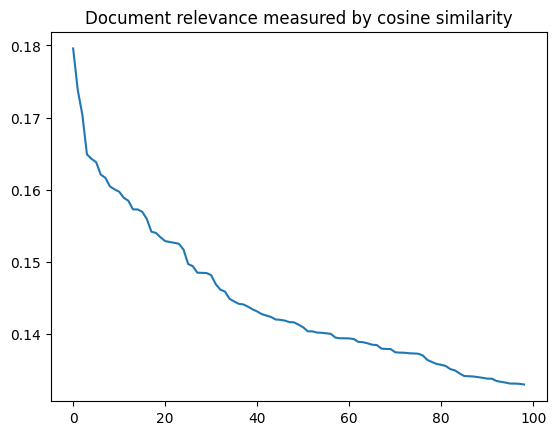

--------------------------
doc: 3938
sci.crypt

The willingness of the majority of the people to give up their freedom in 
exchange for a sense of safety is hardly limited to the USA, and is an 
endemic problem in any human society of any appreciable size.  The structure 
of the US government does try to combat this tendency to some extent, but 
fighting entropy is always a losing battle.  Most people would rather have 
comfort than freedom.  The paradox is that you can't really have the former, 
in the long term, unless you have the latter.

One of the reasons that I probably come across to some people as a weird 
cross between a libertarian and an "establishment tool" is that I end up 
taking an utterly pragmatic view of government.  I don't get up in arms when 
the government fails to protect the interests of the people, because in my 
lifetime it never has--therefore, I have no expectation that it will.  

As a result, I protect my own interests rather than expecting the government

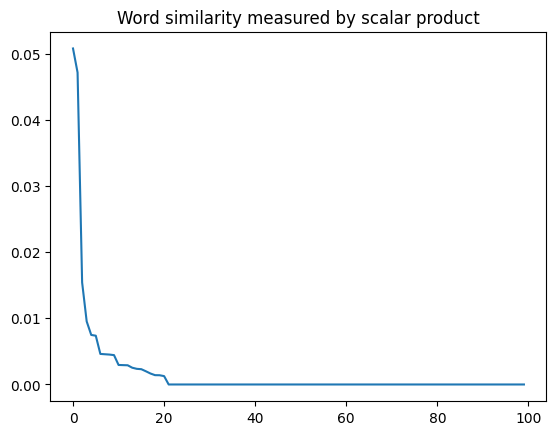

--------------------------
doc: 6894
talk.politics.guns
Here is a press release from the White House.

 President Clinton's Remarks On Waco With Q/A
 To: National Desk
 Contact: White House Office of the Press Secretary, 202-456-2100

   WASHINGTON, April 20 -- Following are remarks by President 
Clinton in a question and answer session with the press:

1:36 P.M. EDT

     THE PRESIDENT:  On February the 28th, four federal
agents were killed in the line of duty trying to enforce the law
against the Branch Davidian compound, which had illegally stockpiled
weaponry and ammunition, and placed innocent children at risk.
Because the BATF operation had failed to meet its objective, a 51-day
standoff ensued.

     The Federal Bureau of Investigation then made every
reasonable effort to bring this perilous situation to an end without
bloodshed and further loss of life.  The Bureau's efforts were
ultimately unavailing because the individual with whom they were
dealing, David Koresh, was dangero

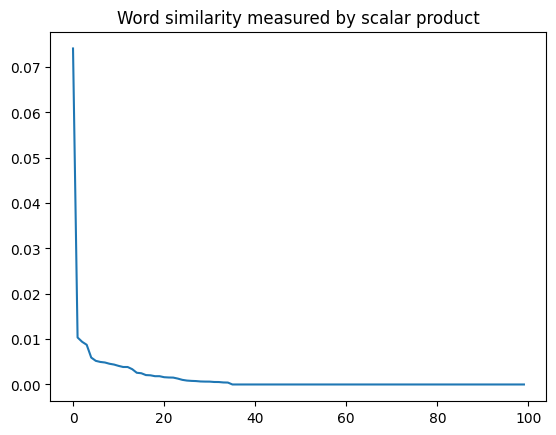

--------------------------
doc: 6880
talk.politics.misc
SECRET PURPOSE OF FALKLANDS WAR;  [with IN-VISIBILITY Technology]

Dr. Beter AUDIO LETTER #74 of 80

Digitized by Jon Volkoff, mail address eidetics@cerf.net

"AUDIO LETTER(R)" is a registered trademark of Audio Books,
Inc., a Texas corporation, which originally produced this tape
recording.  Reproduced under open license granted by Audio
Books, Inc.

-----------------------------------------------------------------

This is the Dr. Beter AUDIO LETTER(R), 1629 K St. NW, Washington,
DC  20006.

   Hello, my friends, this is Dr. Beter.  Today is April 30,
1982, and this is my AUDIO LETTER(R) No. 74.

  It's now been almost one month since war broke out in the South
Atlantic.  On the surface it seems that it's only a dispute
between Argentina and Great Britain over the barren, wind-swept
Falkland Islands and South Georgia Island.  In reality, it's far
more than that.

   The so-called Falklands crisis is just the visible tip of a
gia

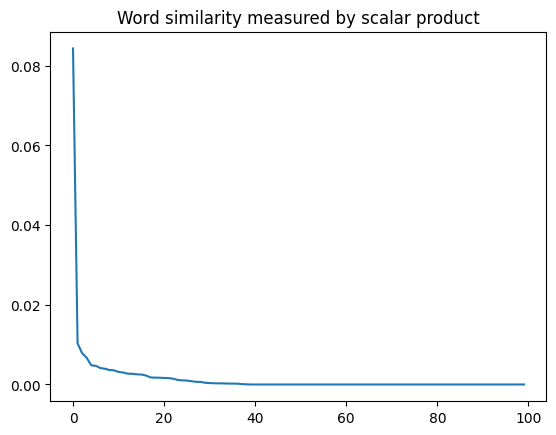

--------------------------
doc: 11255
alt.atheism

Did you miss my post on this topic with the quote from The Indonesian
Handbook and Fred Rice's comments about temporary marriages?  If so, 
I will be glad to repost them.  Will you accept that it just may be 
a practice among some Muslims, if I do?  Or will you continue to claim
that we are all lying and that it is "not practised at all amongst Muslims".

I don't think F. Karner has to tell everyone anything.  Least of all that
he is lying.
shared words: ['indonesian', 'all', 'the', 'that', 'has', 'with', 'to', 'it', 'of', 'are']


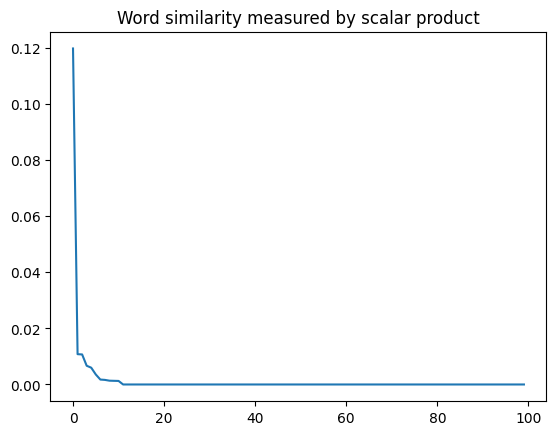

--------------------------
doc: 10836
alt.atheism
Archive-name: atheism/faq
Alt-atheism-archive-name: faq
Last-modified: 5 April 1993
Version: 1.1

                    Alt.Atheism Frequently-Asked Questions

This file contains responses to articles which occur repeatedly in
alt.atheism.  Points covered here are ones which are not covered in the
"Introduction to Atheism"; you are advised to read that article as well
before posting.

These answers are not intended to be exhaustive or definitive. The purpose of
the periodic FAQ postings is not to stifle debate, but to raise its level. If
you have something to say concerning one of these questions and which isn't
covered by the answer given, please feel free to make your point.

Overview of contents:

   "What is the purpose of this newsgroup?"
   "Hitler was an atheist!"
   "The Bible proves it"
   "Pascal's Wager"
   "What is Occam's Razor?"
   "Why it's good to believe in Jesus"
   "Why I know that God exists"
   "Einstein and "God does

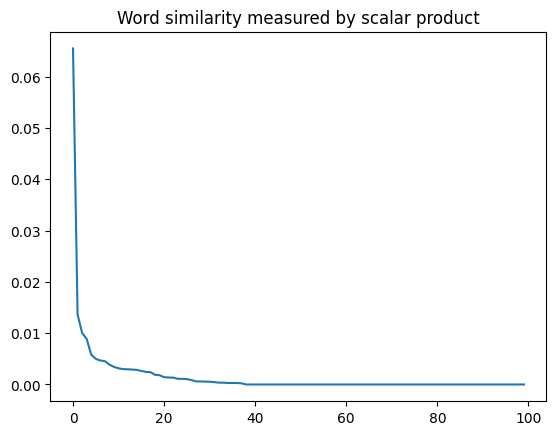

In [75]:
tfidfvect = TfidfVectorizer()
X_train = tfidfvect.fit_transform(newsgroups_train.data)
idx2word = {v: k for k,v in tfidfvect.vocabulary_.items()}
y_train = newsgroups_train.target

analyze_similar_docs(5000, X_train, newsgroups_train, idx2word)

Notemos la preponderancia de artículos como: the, it, of, etc. Para corregir eso utilizamos una lista de stop words en ingles. 

--------------------------
doc: 5000
alt.atheism



I pointed out the secession movement in Aceh which has also been
brutally dealt with in the past by the Indonesian government.  The
harshly with all secessionist movements.
the evidence, it appears to me that the Indonesian government has dealt
very harshly with all secession movements.

I know that the head of the Indonesian armed forces for a very long time
was Benny Murdani -- a "Christian".  Indonesia has been heavy handed in
East Timor for a long time , even when Murdani was head of the armed
forces.  The people who make up the
Indonesian government are in general motivated by national interests,
not religious ones.


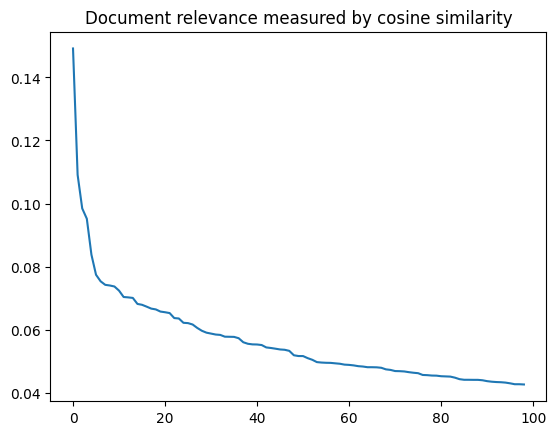

--------------------------
doc: 11255
alt.atheism

Did you miss my post on this topic with the quote from The Indonesian
Handbook and Fred Rice's comments about temporary marriages?  If so, 
I will be glad to repost them.  Will you accept that it just may be 
a practice among some Muslims, if I do?  Or will you continue to claim
that we are all lying and that it is "not practised at all amongst Muslims".

I don't think F. Karner has to tell everyone anything.  Least of all that
he is lying.
shared words: ['indonesian', 'dis', 'dis_pkt', 'dis_pkt9', 'disa', 'disabilities', 'disability', 'disable', 'disabled', 'disables']


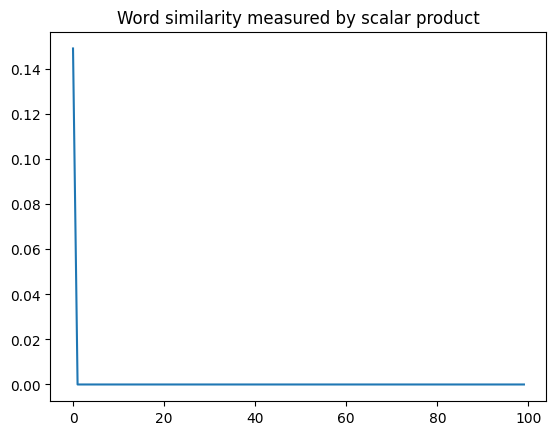

--------------------------
doc: 3938
sci.crypt

The willingness of the majority of the people to give up their freedom in 
exchange for a sense of safety is hardly limited to the USA, and is an 
endemic problem in any human society of any appreciable size.  The structure 
of the US government does try to combat this tendency to some extent, but 
fighting entropy is always a losing battle.  Most people would rather have 
comfort than freedom.  The paradox is that you can't really have the former, 
in the long term, unless you have the latter.

One of the reasons that I probably come across to some people as a weird 
cross between a libertarian and an "establishment tool" is that I end up 
taking an utterly pragmatic view of government.  I don't get up in arms when 
the government fails to protect the interests of the people, because in my 
lifetime it never has--therefore, I have no expectation that it will.  

As a result, I protect my own interests rather than expecting the government

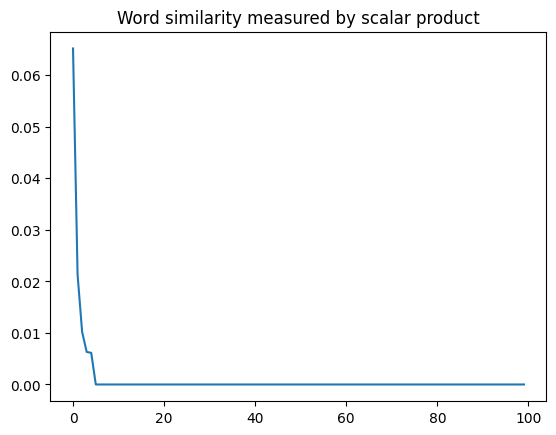

--------------------------
doc: 8316
talk.politics.guns
From article <1993Apr18.000152.2339@gnv.ifas.ufl.edu>, by jrm@gnv.ifas.ufl.edu:

Only irrational fools such as yourself are set against RKBA.  There are
*plenty* of people who support it.


The government will be overthrown *long* before that happens.  A *huge* 
millitia composed of all available men and women who care about their
country will defeat the forces of the evil Klintonistas.  The people
*will* prevail!

Oh, so you think armed citizens alone can't overthrow the government?
Consider this:  do you think *all* law enforcement officials and members
of the Armed Forces will turn against the people that they are entrusted
to serve?  Not hardly.  You can count on a lot of people in the Army,
Marines, Air Force, Navy, National Guard, police officers, and so on
joining in the cause to defend the liberties and freedoms of American
citizens.  COUNT ON IT!  THE GOVERNMENT WILL NOT BE ABLE TO DISARM
EVERYONE WITHOUT STARTING A CIVIL

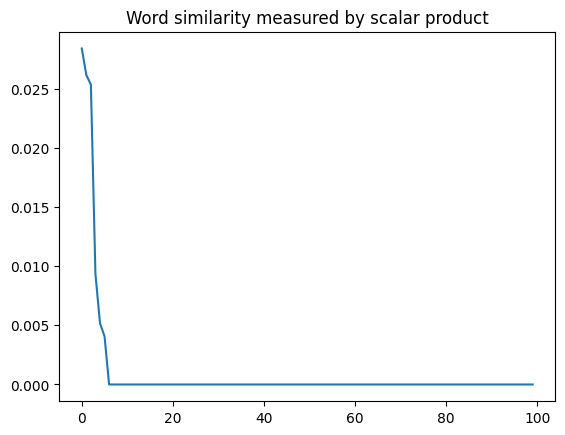

--------------------------
doc: 3823
talk.politics.mideast


	And all this time I thought it was the US & Britian invading
Normandy, the constant, round the clock bombing, and the fact that the
Germans were fighting on two fronts.  How silly of me.  :)

	This is not to devalue the actions of the resistance
movements, but resistance movements did not defeat the Nazis.


	Israel has repeatedly stated that it will leave when the
Lebanese government shows that it can prevent attacks on Israel, and
when the Syrians agree to leave.

	The Lebanese have not tried diplomacy for very long, or maybe
they're not capable of getting rid of the Syrians and Iranians who
occupy their land.  If they closed down the Hezbolah, and negotiated a
withdrawl of Syrian forces, Israel would be happy to leave.

Adam

Adam Shostack 				       adam@das.harvard.edu
shared words: ['movements', 'forces', 'government', 'long', 'time', 'dis_pkt', 'dis_pkt9', 'disa', 'disabilities', 'disability']


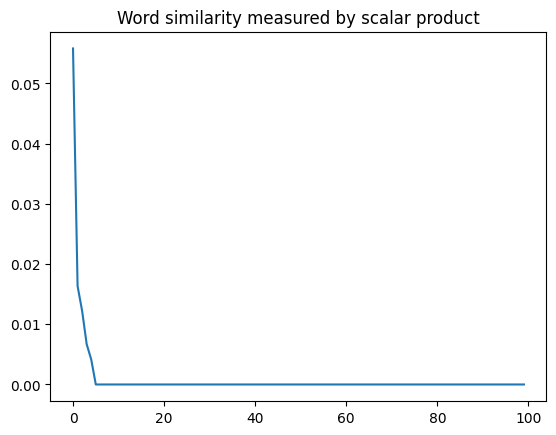

--------------------------
doc: 670
talk.politics.misc

I'm afraid that I've lost the thread here.  I didn't suggest that all 
government regulations be subject to referenda.  So I don't follow the 
comments above.


I mean that an ideology that treats all government regulation as equally
undesirable and seeks to abolish all regulations is unlikely to draw
support among more than a miniscule portion of the electorate.

Furthermore, I am suggesting that such a plan is not feasible in an
industrial society because the weight of litigation and/or misery it
would produce would effectively crush productive effort.

No, I'm not surprised.  I just think it's interesting that on one hand
libertarians assume a limited government can be decreed, yet on the other
posit an entire government made up of people who carry guns.  (I realize
that many libertarians assume that such a government will be 
counterbalanced by a fully armed citizenry, but it is worth noting that
widespread civilian ownership 

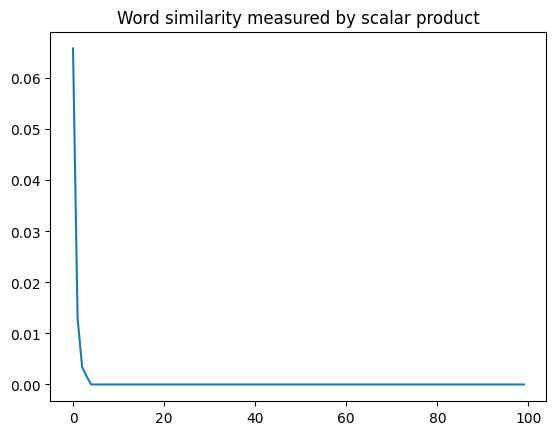

In [76]:
tfidfvect = TfidfVectorizer(stop_words='english')
X_train = tfidfvect.fit_transform(newsgroups_train.data)
idx2word = {v: k for k,v in tfidfvect.vocabulary_.items()}
y_train = newsgroups_train.target

analyze_similar_docs(5000, X_train, newsgroups_train, idx2word)

Se ve que ciertos documentos son relevantes ya que comparten conceptos con el documento original como ser: represión/poder estatal (3938, 8316), levantamientos armados (8316); pero otros solo son relevantes por el pais mencionado en el documento original (11255), o por mencionar la palabra gobierno (3823, 670)

--------------------------
doc: 10000
rec.autos
I have to disagree with this.  I have a 92 Z28 with a 350 and a 4-speed auto
w/ overdrive, and it is really better that way.  Chevy autos are reknowned
for their long life and ability to handle copious amount of power.  I live 
in the Dallas area, and a manual would be much harder to drive in the traffic 
here.  Now if I still lived out in the sticks like I used to, a manual would be
more fun.  

Safety-wise, an auto is less distracting...I would hate to have to be    
shifting gears while I was trying to ease into traffic in the freeways here.
Performance-wise, I can hold my own against any stock 5.0 Mustang or 5.0
Camaro w/ a five speed.  

All of this IMHO... :)






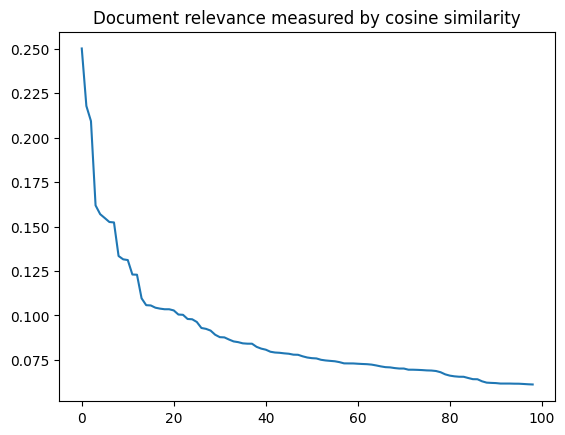

--------------------------
doc: 5009
comp.sys.mac.hardware
"auto
from
shared words: ['auto', 'dirtiest', 'dirty', 'dis', 'dis_pkt', 'dis_pkt9', 'disa', 'disabilities', 'disability', 'disable']


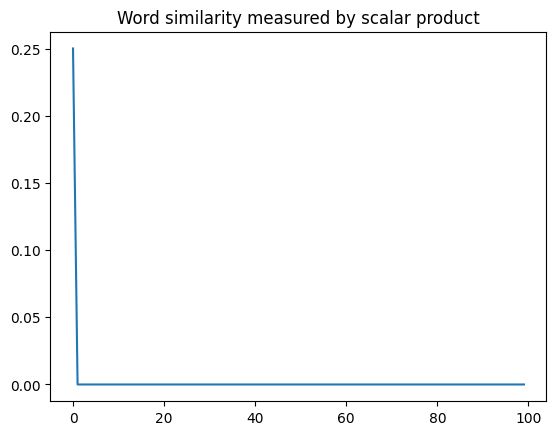

--------------------------
doc: 1500
rec.autos
In rec.autos you write:


This McLaren auto-transmission (I still think it's only half auto,
but You may be right) has NOTHING to do with Your GM, Chrysler, Volvo,
or whatever auto transmission. It's a normal manual transmission
gearbox with clutch and all, but there are servo motors, which do
the shifting. 

That means, there is no power loss in the drivetrain (if You take out 
minimal mechanical friction), and the sami-auto transmissions 
(Ferrari, Williams, McLaren(?),...) don't tell You, when to shift,
either. However, these transmissions share an important disadvantage
with Your stock auto-trannie: They are EXPENSIVE.

As long as these servo-shifted gearboxes aren't available on 
'normal' cars I'm gonna stick with my manual. I just can't see an
advantage to make up for two grand I lose in this deal and the
loss in mileage and power (except maybe in real heavy traffic). But
then I drive mostly on the autobahn and country roads anyway.


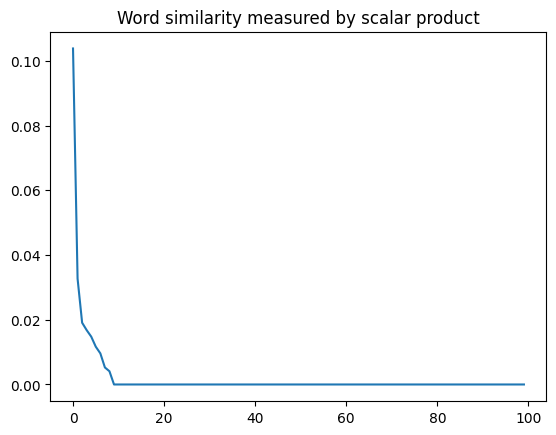

--------------------------
doc: 9503
rec.autos



Back to the F1 stuff for a second, note that the `auto' tranny in F1
_STILL_ shifts at the driver's command, not some preselected schedule.  The
driver still controls the shifting, not the transmission. 


          ^^^^^^^^^ ^^^^^^^^^^^

I have yet to see a torque multiplier installed on a production automobile. 
Such systems do exist, but none are presently installed in production autos
that I am aware of.  These are commonly called viscous drive CVTs or
fluidic amplifiers. 


What the convertor _does_ allow is for the engine to be closer to its
torque peak during the launch before a clutched car can fully engage it's
driveline.  Chevy proved it many years ago with the '70 Camaro (ETs and
terminal 1/4 mile times were close enough tpo be identical for 4 speed and
auto cars).  Note that this is also the major reason that an auto car can
get away with fewer gears than a manual, the slip in the convertor makes up
for the fewer ratios (and

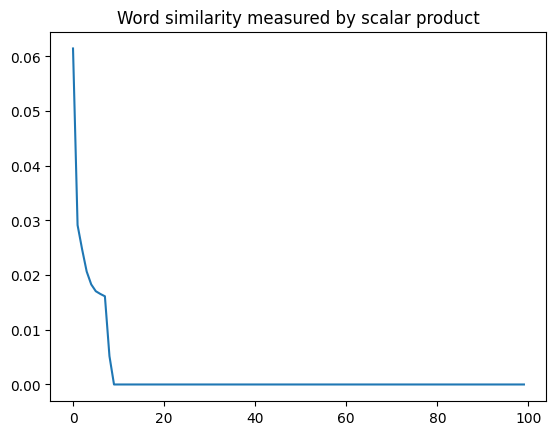

--------------------------
doc: 960
rec.autos


all of my HO's disagree with your HO's.  I LOVED Dallas rush hour in my stick..
detested it in the auto(like i did any other time in the auto...).  Of course,
Dalls rush hours are nothing, from what i hear..if i lived in LA, i might
be of a different persuasion.  And, just for the record, rarely do you shift
gears when merging into traffic..that is what 5 speeds are good for..4th is
good up through around 80-90, most of the time, so you can just wind it out..
it's not going to hurt anything, and keeps it in the powerband anyway..
only shift into top gear when you are exceeding redline in 4th(fairly rare,
unless you drive a ferrari or some such, i'd bet) or when you hit cruising 
speed where you feel comfortable(or when my mother is sitting in the 
passanger seat complaining about how you wind her "poor little engine" way
too hi :-)
Just my HO's..
shared words: ['auto', 'traffic', 'gears', 'dallas', 'speed', 'disagree', 'lived', 'drive', '

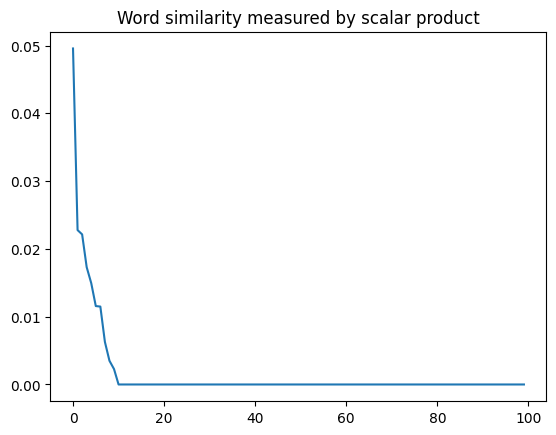

--------------------------
doc: 2712
rec.autos
Now, my ego with regards to my shifting ability is as big as anyone else's, but
I just ordered my first car with an auto trans. I wasn't planning on it; but
after driving a few I was convinced: Things have changed since the days of 
"Slip 'n' Slide Withe Powerglide". They shift *better* than I do, there's no
clutch to wear out (Honda wanted $800 for my 4WD wagon last year!- got it done
for $500), it only costs about 5% in gas milage on the highway and it makes it
easier to concentrate on all the radios in my car ;-)

(Oddly enough, while two of my best friends- both in the auto industry here in the 
Motor City- have switched wholeheartedly to autos, their wives *insist* on 
manual. Shift envy?)

Braggadocio aside, given today's technology and the warranties they're handing 
out the auto trans seemed like an excellent choice. Call me a convert.
shared words: ['auto', 'shifting', 'manual', 'autos', 'ability', 'better', 'like', 'disagreeing',

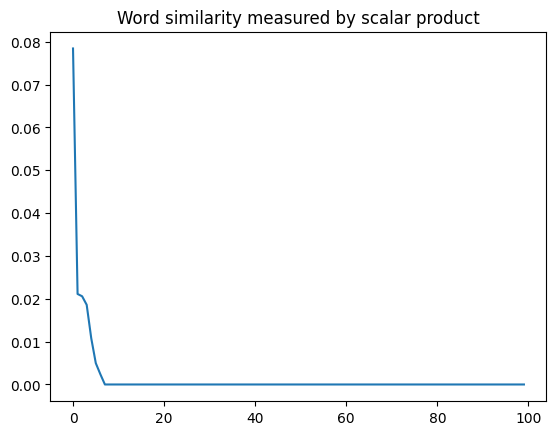

In [77]:
analyze_similar_docs(10000, X_train, newsgroups_train, idx2word)

Con el documento 10000 se nota una precisión mucho mejor ya que de los 5 documentos 4 (5009, 1500) son relevantes a la temática de transmisión manual vs automatica en situaciones de calle, siendo el otro documento (9503) sobre transmisión manual en autos de formula 1. Como interpretación podemos decir que el tópico del documento original es mucho mas especifico al mundo de los automotores, especialmente si se utilizan las palabras como manual, auto, shift, etc. 

--------------------------
doc: 3500
talk.politics.misc






Unfortunately, there's not much we can learn from the statistics presented
here either.  Due to rounding, the 1991 est. for LSD could be anywhere
from .550 to .649 and the 1992 est. could be anywhere from .850 to .949.
This means that the actual change (if you believe these statistics in the
first place) was anywhere from 31% to 73%.  Similarly the increase in
cocaine use could be anywhere from 18% to 66% and the increase of
crack use could be anywhere from 29% to 120%.  This doesn't even
take into account the margin of error which isn't provided here.


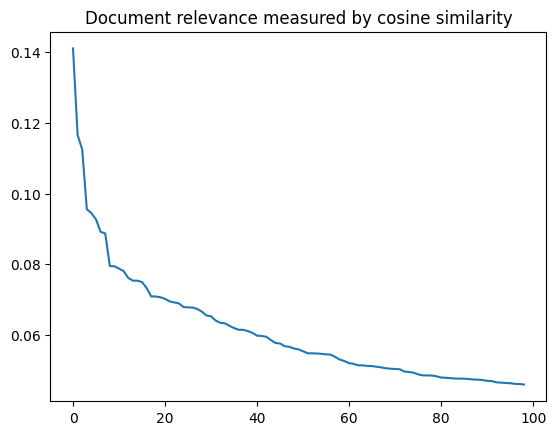

--------------------------
doc: 253
talk.politics.misc
The article that follows was taken from the Wednesday, April 14,
1993 issue of USA Today ("Drug Use Up At Younger Age" by Mike
Snider, p. 1A).

    Drug use is on the rise among kids as young as eighth graders -
    usually 13 - and they're using more LSD and inhalants like glue
    and air fresheners, says a new survey.

    The annual National High School Senior Survey on Drug Abuse finds
    "statistically significant increases" in eighth-graders' use of
    many drugs, including marijuana, cocaine, crack, LSD and inhalants.

    "We may be in danger of losing some ... hard-won ground (in reducing
    drug use) as a new, more naive generation of youngsters enters
    adolescence," says Lloyd Johnston, University of Michigan, chief
    researcher on the study sponsored by the Department of Health and
    Human Services.

    But drug use among high school seniors is continuing a decade-long
    decline.

    The study of 50,000 s

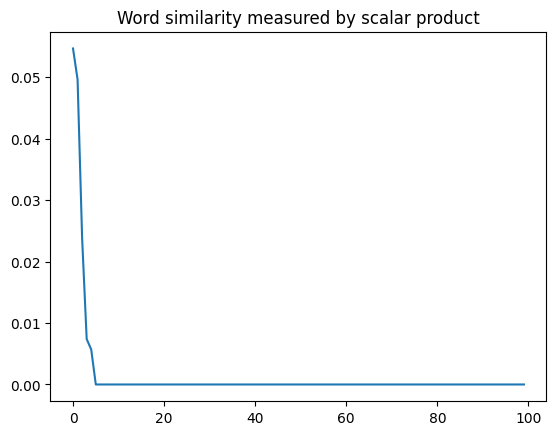

--------------------------
doc: 1463
sci.electronics
B
)>>>>>>>>> Votre host est mal configure... <<<<<<<<<<<<


)Bonjour Sylvain,
)	J'ai travaille avec le hc11 il y a 3 ans et je ne me souviens pas de toutes les possibilites mais je vais quand meme essayer de t'aider.

)	Je ne crois pas que downloader une programme directement dans le eeprom soit une bonne idee (le eeprom a une duree de vie limitee a 10 000 cycles il me semble). Le communication break down vient peut-etre du fait que le eeprom est long a programmer (1ms par 8 bytes mais c'est a verifier) et que les delais de transfer de programme s19 vers la memoire sont excedes. Normalement, les transferts en RAM du code s19 est plus rapide car le RAM est plus rapide que le eeprom en ecriture.

)	C'est tout ce que ma memoire me permet de me souvenir!

)Bonne chance,

Oh yeah easy for him to say!...

shared words: ['est', 'dis', 'dis_pkt', 'dis_pkt9', 'disa', 'disabilities', 'disability', 'disable', 'disabled', 'disables']


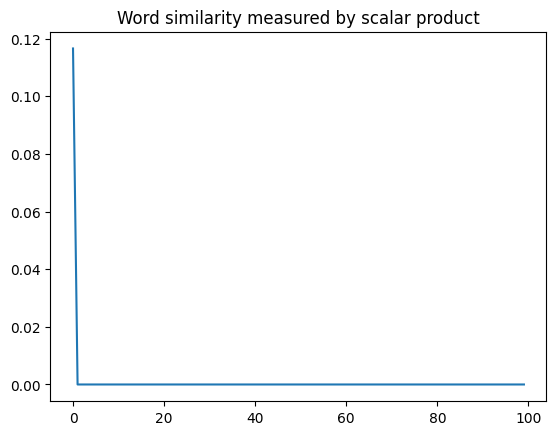

--------------------------
doc: 8603
talk.politics.guns

Why?  If you're not a threat, you're not affected at all.


Why?  I note that the available psych info says that feelings of
security INCREASE.  The victimization stats say that that increase
is rational.


Yes, they are, but how?


Nope - that doesn't happen.  Instead the switch (among those who
change behaviors) to property crimes.  That's an improvement even if
the economic take is unchanged.  Sure - not everyone switches, but
they were killing before.

-andy
shared words: ['increase', 'change', 'doesn', 'dirty', 'dis', 'dis_pkt', 'dis_pkt9', 'disa', 'disabilities', 'disability']


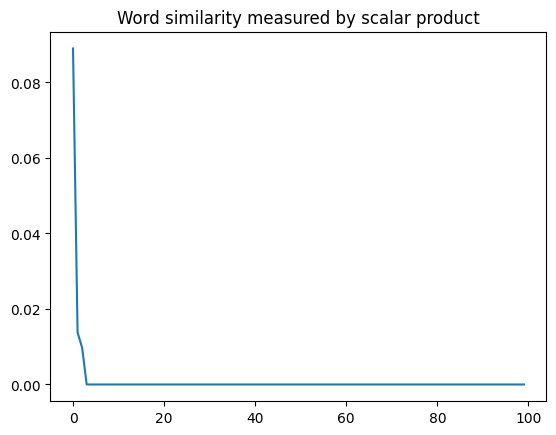

--------------------------
doc: 4908
comp.windows.x

Depends on the nature of the "rounding."  X allows the user to do bit
arithmetic on pixel values, (i.e.,  XOR foreground and backgroun pixel
values together to calculate a foreground color that when used with a
function of GXxor fill change foreground to background and vice-versa).
If your rounding does not preserve these types of calculations then 
clients that use them will break.

	Ken
shared words: ['rounding', 'change', 'use', 'dis', 'dis_pkt', 'dis_pkt9', 'disa', 'disabilities', 'disability', 'disable']


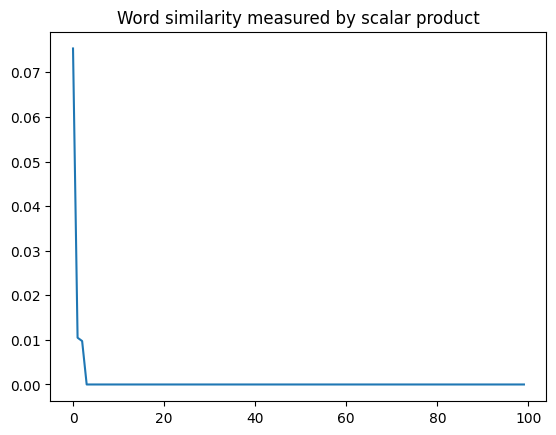

--------------------------
doc: 575
alt.atheism


I agree, I reckon it's television and the increase in fundamentalism.. You
think its the increase in pre-marital sex... others thinks its because
psychologists have taken over the criminal justice system and let violent
criminals con them into letting them out into the streets... others think
it's the increase in designer drugs... others think it's a communist plot.
Basically the social interactions of all the changing factors in our society
are far too complicated for us to control. We just have to hold on to the
panic handles and hope that we are heading for a soft landing. But one
things for sure, depression and the destruction of the nuclear family is not
due solely to sex out of marriage.

Jeff.

shared words: ['increase', 'dis', 'dis_pkt', 'dis_pkt9', 'disa', 'disabilities', 'disability', 'disable', 'disabled', 'disables']


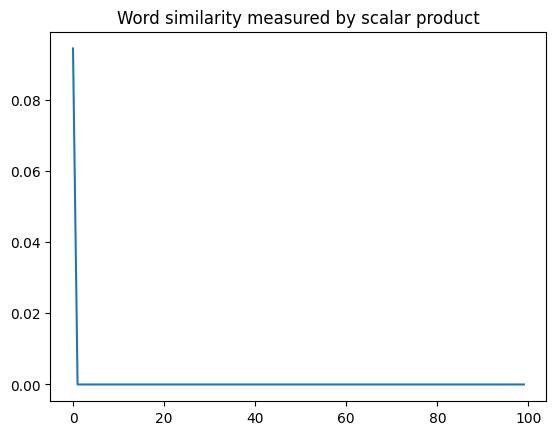

In [78]:
analyze_similar_docs(3500, X_train, newsgroups_train, idx2word)

En este caso no se obtuvieron resultados relacionados con el consumo de drogas o sobre estadisticas de ningun tipo, tematicas que aborda el documento original.

--------------------------
doc: 7600
soc.religion.christian
All of the arguments concerning the Sabbath ought to make the point
pretty clear - anyone outside of the Catholic or Orthodox orAnglican or
Monophysite churches ourght to worship on Saturday if they are really
sola scriptura.  Otherwise, they are following a law put into effect by
the Church, and only the above Chruches really recognize any power of
the Chruch to do so.

Andy Byler

[You will note that nothing in the FAQ said anything about the Church
establishing or changing a law.  The argument against the Sabbath is
that it is part of the ceremonial law, and like the rest of the
ceremonial law is not binding on Christians.  This argument is based
on Paul's letters, Acts, and in a more general sense, Jesus'
teachings.  Further, most people argue that Scripture shows worship
occuring on Sunday, and Paul endorsing it.  I understand that these
points are disputed, and do not want to go around the dispute one more
time.  The poi

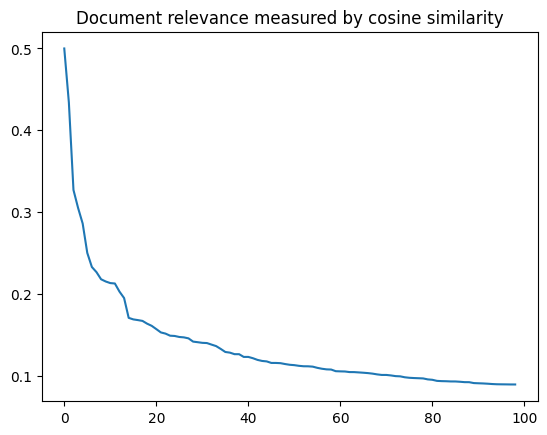

--------------------------
doc: 3280
soc.religion.christian
[In response to some of the discussions on the Sabbath, Andrew Byler
commented that if we really followed sola scriptura we would worship
on Saturday -- the change to Sunday was a law made by the Church, and
we don't acknowledge its authority to make laws.  I noted that
Protestants do not consider Sunday worship a law.  --clh]

He was not referring to the FAQ but to the five Sabbath Admissions posted
on the bible study group.  This is what prompted someone to send the FAQ
to me.

n> ceremonial law is not binding on Christians.

You cannot show, from scripture, that the weekly Sabbath is part of the
ceremonial laws.   Before you post a text in reply investigate its context.

Can the churches also decide what is and is not sin?  Interesting.  Where
there is no divine imperative of course we must establish rules of
operation.  But we cannot be as creative with what God has explicitly
spoken on.

Darius
shared words: ['sabbath', '

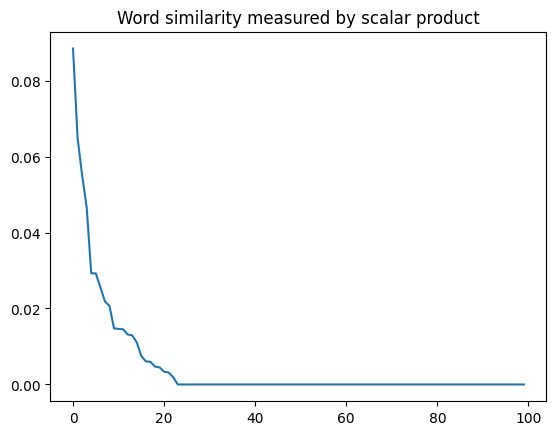

--------------------------
doc: 2043
soc.religion.christian
Someone sent me this FAQ by E-mail and I post my response here.

[I'm not enforcing the inclusion limits on this FAQ because most
of our readers probably haven't seen it.  --clh]

Christ warns that anyone who "breaks one of the least of these
commandments *and* teaches otheres to do the same will be called least in
the kingdom of heaven" (Matt. 5:19.  This FAQ is so full of error that I
must respond to it.  I hope that whoever maintains will remove from it the
partisan theology.


1.  The law was known to man before it was revealed on Mount Sinai.  Rom
4:15 notes that "where no law is, there is no transgression."  Not only
did sin exist before Sinai (Eden), but the Sabbath was kept before it
was revealed on Sinai (Ex 16).

2.  The problem with the first covenant was not the law, but the promise
which undergirded it.  God wanted to perform his will in the lives of the
people, but in their ignorance after 400 years of slavery, t

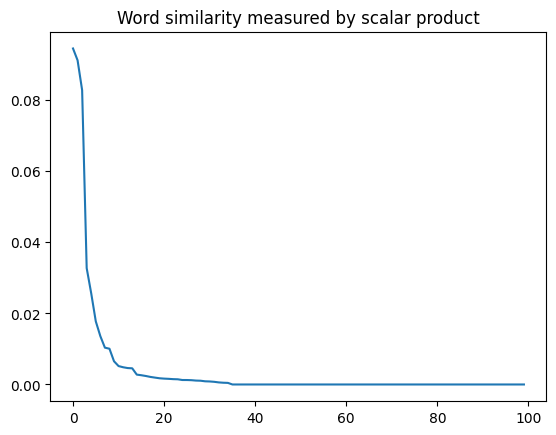

--------------------------
doc: 10962
soc.religion.christian


First of all, "ceremonial law" is an extraScriptural term.  It is sometimes
used as a framework to view Scripture.  But if you look at Collosions,
without going into it with the assumption that the Sabbath cannot be 
a ceremonial law, you will see that it does refer to the sabbath.

against us to His cross, and therefore we should not be judged in what
what food we eat, what we drink, the keeping of new moons and holy days,
or the keeping of the sabbath.

The word for sabbath in this verse is "sabbaton" and is used throughout the
New Testament to refer to the 7th day.  If there is any Scripture from
which we get the idea of the ceremonial law, this is one of them, and the
sabbath is listed among the ceremonial laws.

If one goes into this with the fundamental assumption "the sabbath cannot
be a ceremonial law" then he will have to find some way around it, like
saying that this can only refer to the other sabbath holy days b

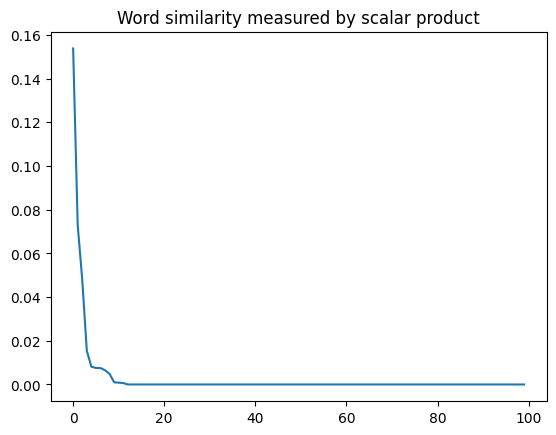

--------------------------
doc: 9903
soc.religion.christian
I wrote in response to dlecoint@garnet.acns.fsu.edu (Darius_Lecointe):


Was Paul a God too? Is an interpretation of the words of Paul of higher
priority than the direct word of Jesus in Matt5:14-19? Paul begins
Romans 14 with "If someone is weak in the faith ..." Do you count
yourself as one who is weak in the faith?


Yes, but what does the Bible have to say? What did Jesus say? Paul
closes Romans 14 with, "On the other hand, the person with doubts about
something who eats it anyway is guilty, because he isn't acting on his
faith, and any failure to act on faith is a sin." Gaus, ISBN:0-933999-99-2
Have you read the Ten Commandments which are a portion of the Law? Have
you read Jesus' word in Matt5:14-19? Is there any doubt in your mind
about what is right and what is sin (Greek hamartia = missing the mark)?


Whereas, the Ten Commandments and Jesus' words in Matt5:14-19 are fairly
clear, are they not?


Matt5:14-19 doesn't a

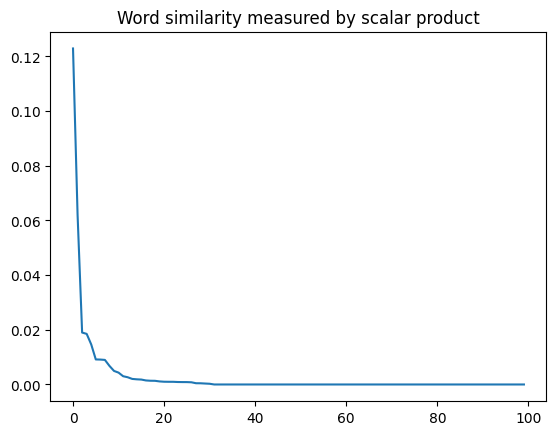

--------------------------
doc: 8979
talk.religion.misc


I think the passage you're looking for is the following.

Matthew 5:17    "Think not that I have come to abolish the law and the 
prophets; I have come not to abolish them but to fulfil them. 
Matthew 5:18   For truly, I say to you, till heaven and earth pass away, 
not an iota, not a dot, will pass from the law until all is accomplished. 
Matthew 5:19   Whoever then relaxes one of the least of these commandments 
and teaches men so, shall be called least in the kingdom of heaven; but he 
who does them and teaches them shall be called great in the kingdom of 
heaven. 
Matthew 5:20   For I tell you, unless your righteousness exceeds that of 
the scribes and Pharisees, you will never enter the kingdom of heaven. 

There are several problems with this.  The most serious is that the
Law was regarded by Jews at the time (and now) as binding on Jews, but
not on Gentiles.  There are rules that were binding on all human
beings (the so-c

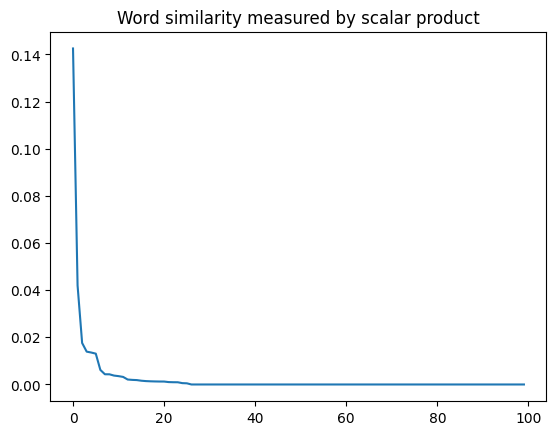

In [79]:
analyze_similar_docs(7600, X_train, newsgroups_train, idx2word)

De nuevo vemos una mejora en los resultados, posiblemente debido a la especificidad del tema.

--------------------------
doc: 200
talk.politics.guns

I first read and consulted rec.guns in the summer of 1991.  I
just purchased my first firearm in early March of this year.


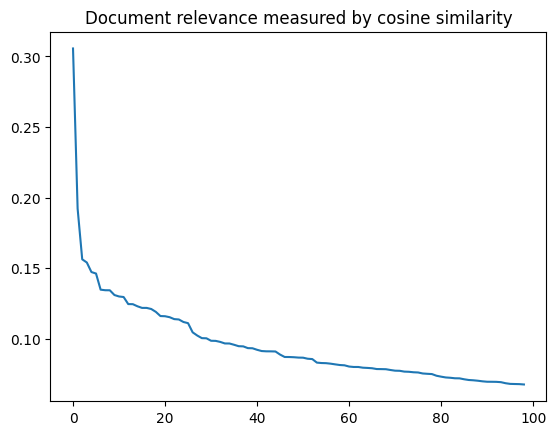

--------------------------
doc: 6538
talk.politics.guns

I'd like to point out that I was in error - "Terminator" began posting only 
six months before he purchased his first firearm, according to private email
from him.

I can't produce an archived posting of his earlier than January 1992,
and he purchased his first firearm in March 1992.

I guess it only seemed like years.

Back to your regularly scheduled flame fest.

shared words: ['firearm', 'purchased', 'march', 'dis_pkt9', 'disa', 'disabilities', 'disability', 'disable', 'disabled', 'disables']


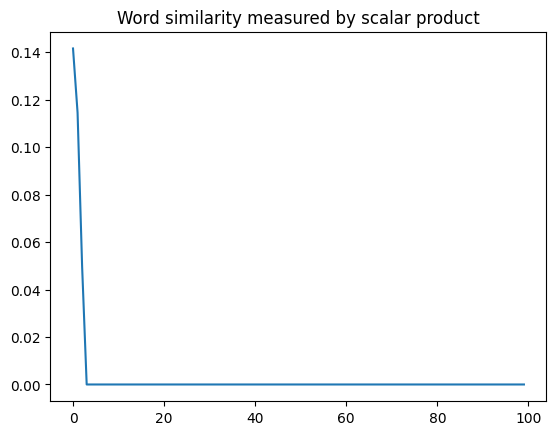

--------------------------
doc: 532
talk.politics.guns
} 	The vast majority get through life without ever having to
} 	own, use or display a firearm.
} ...
} 
}       Given society
} 	as we now experience it - it seems safer to get rid of
} 	as many guns as possible.

Considering that the uses include self defense, hunting, target shooting
and collecting, I don't buy the notion that the vast majority of people
don't "own, use or display a firearm".

But let's say your contention is true.  What's the point of "get[ting]
rid of as many guns as possible", if they weren't being used anyway?
shared words: ['firearm', 'guns', 'dirty', 'dis_pkt', 'dis_pkt9', 'disa', 'disabilities', 'disability', 'disable', 'disabled']


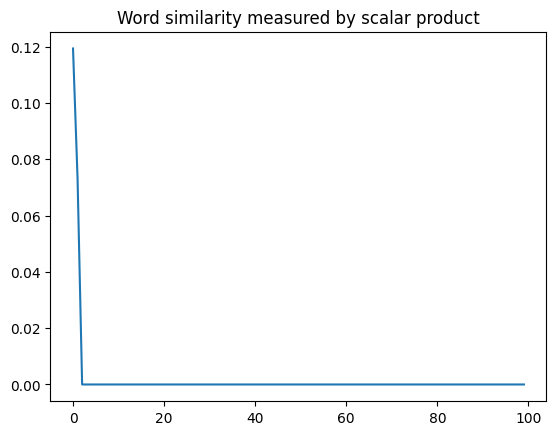

--------------------------
doc: 2519
rec.motorcycles

I have a cheap solar charger that I keep in my car.  I purchased it via
some mail order catalog when the 4 year old battery in my Oldsmobile would
run down during Summer when I was riding my bike more than driving my car.
Knowing I'd be selling the car in a year or so, I purchased the charger.
Believe it or not, the thing worked.  The battery held a charge and
energetically started the car, many times after 4 or 5 weeks of just
sitting.

Eventually I had to purchase a new battery anyway because the Winter sun
wasn't strong enough due to its low angle.

I think I paid $29 or $30 for the charger.  There are more powerful, more
expensive ones, but I purchased the cheapest one I could find.

I've never used it on the bike because I have an E-Z Charger on it and
keep it plugged in all the time the bike is garaged.
shared words: ['purchased', 'summer', 'year', 'just', 'dis_pkt9', 'disa', 'disabilities', 'disability', 'disable', 'disabled'

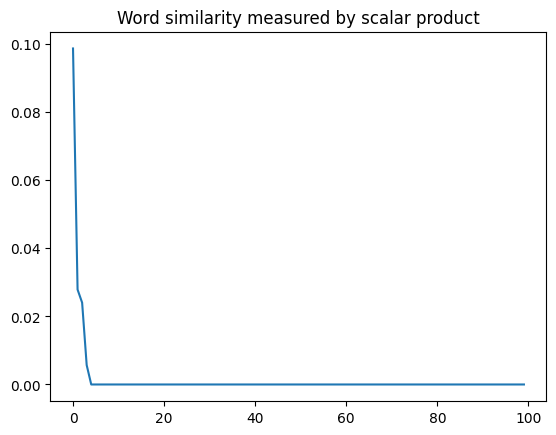

--------------------------
doc: 3618
rec.sport.hockey



Woops!  This is rec.sport.hockey! Not rec.sport.golf!  Hope you check the
newsgroup header next time before posting!

Steve

shared words: ['rec', 'dirty', 'dis', 'dis_pkt', 'dis_pkt9', 'disa', 'disabilities', 'disability', 'disable', 'disabled']


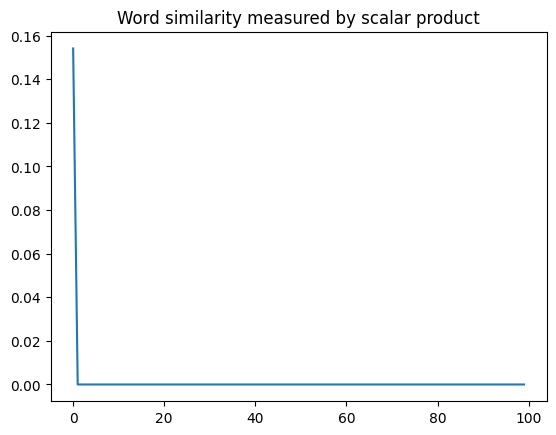

--------------------------
doc: 1214
rec.autos
Archive-name: rec-autos/part1

[most recent changes, 15 March 1993: addition of alt.autos.karting -- rpw]

               === Welcome to Rec.Autos.* ===

This article is sent out automatically each month, and contains a general
description of the purpose of each of the automotive newsgroups, and
some suggested guidelines for discussions.  The keywords `Monthly Posting'
will always appear to make killing this article easy for users of
newsreaders with kill facilities.  This article is posted to all autos
groups, but followups are directed only to rec.autos.  If you don't
understand what this means, ask your system administrator for help, or at
least for copies of the newuser documentation.  Failing that, please
subscribe to the newsgroup news.announce.newusers and read the
documentation provided there.

Introduction to the Rec.Autos newsgroup hierarchy:

rec.autos.tech

is intended for technical discussions of automobiles, their design,
con

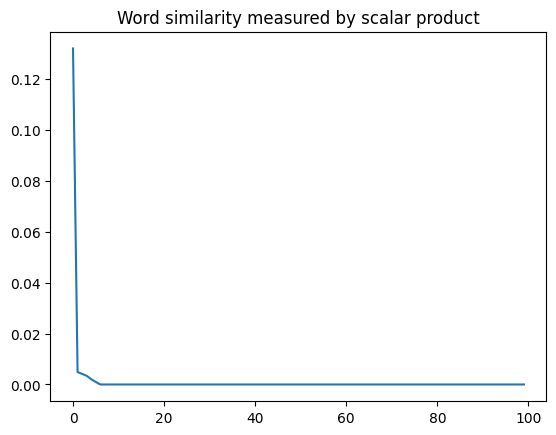

In [80]:
analyze_similar_docs(200, X_train, newsgroups_train, idx2word)

# Clasificacion con Naive Bayes

Comparamos primero una clasificacion sin stop words y luego una con stop words.

In [81]:
tfidfvect = TfidfVectorizer()
X_train = tfidfvect.fit_transform(newsgroups_train.data)

# X_test = tfidfvect.transform(newsgroups_test.data)
# y_test = newsgroups_test.target
clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred =  clf.predict(X_train)
f1_score(y_train, y_pred, average='macro')

0.7914858700540199

In [82]:
tfidfvect = TfidfVectorizer(stop_words='english')
X_train = tfidfvect.fit_transform(newsgroups_train.data)

# X_test = tfidfvect.transform(newsgroups_test.data)
# y_test = newsgroups_test.target
clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred =  clf.predict(X_train)
f1_score(y_train, y_pred, average='macro')

0.8592086788224457

Ahora hacemos grid search con modelos de Naive Bayes Multinomial y ComplementNB

In [84]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, classification_report
from sklearn.datasets import fetch_20newsgroups

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', MultinomialNB())
])

parameters = [
    {
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'tfidf__max_df': [0.75, 0.95, 1.0],
        'tfidf__min_df': [1, 2, 5],
        'clf': [MultinomialNB()],
        'clf__alpha': [0.01, 0.1, 0.5, 1.0],
    },
    {
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'tfidf__max_df': [0.75, 0.95, 1.0],
        'tfidf__min_df': [1, 2, 5],
        'clf': [ComplementNB()],
        'clf__alpha': [0.01, 0.1, 0.5, 1.0],
        'clf__norm': [True, False],
    }
]

grid_search = GridSearchCV(pipeline, parameters, cv=3,
                           scoring='f1_macro', verbose=1, n_jobs=12)


In [85]:
grid_search.fit(newsgroups_train.data, y_train)
print("\nBest F1_macro score found on development set:")
print(grid_search.best_score_)
print("\nBest parameters set found on development set:")
print(grid_search.best_params_)

Fitting 3 folds for each of 216 candidates, totalling 648 fits



Best F1_macro score found on development set:
0.7671229015322751

Best parameters set found on development set:
{'clf': ComplementNB(), 'clf__alpha': 0.1, 'clf__norm': True, 'tfidf__max_df': 0.75, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}


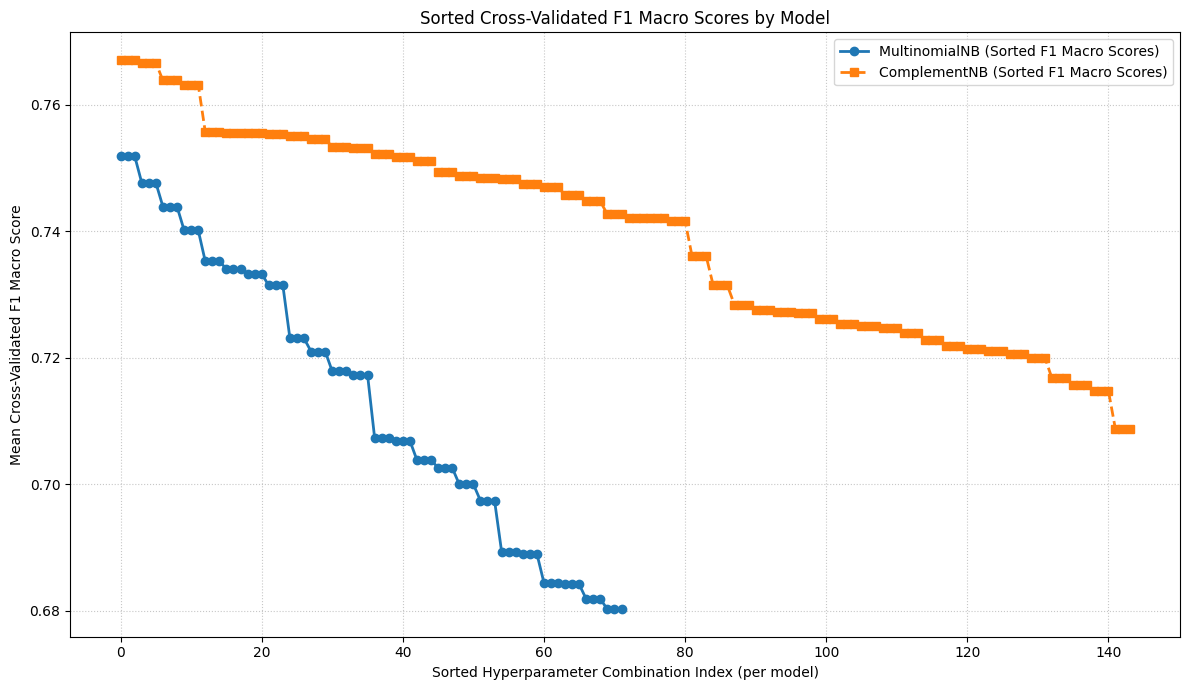

In [86]:
import pandas as pd

cv_results_df = pd.DataFrame(grid_search.cv_results_)
cv_results_df['model_name'] = cv_results_df['param_clf'].apply(lambda clf: clf.__class__.__name__)

plt.figure(figsize=(12, 7))

# Data for MultinomialNB
mnb_df = cv_results_df[cv_results_df['model_name'] == 'MultinomialNB'].copy()
if not mnb_df.empty:
    mnb_mean_scores = mnb_df['mean_test_score'].copy()
    sorted_mnb_scores = mnb_mean_scores.sort_values(ascending=False).reset_index(drop=True)
    if not sorted_mnb_scores.empty:
        plt.plot(sorted_mnb_scores.index, sorted_mnb_scores.values,
                 marker='o', linestyle='-', linewidth=2, markersize=6,
                 label='MultinomialNB (Sorted F1 Macro Scores)')

# Data for ComplementNB
cnb_df = cv_results_df[cv_results_df['model_name'] == 'ComplementNB'].copy()
if not cnb_df.empty:
    cnb_mean_scores = cnb_df['mean_test_score'].copy()
    sorted_cnb_scores = cnb_mean_scores.sort_values(ascending=False).reset_index(drop=True)
    if not sorted_cnb_scores.empty:
        plt.plot(sorted_cnb_scores.index, sorted_cnb_scores.values,
                 marker='s', linestyle='--', linewidth=2, markersize=6,
                 label='ComplementNB (Sorted F1 Macro Scores)')

plt.xlabel("Sorted Hyperparameter Combination Index (per model)")
plt.ylabel("Mean Cross-Validated F1 Macro Score")
plt.title("Sorted Cross-Validated F1 Macro Scores by Model")

# Add legend only if at least one line was plotted
if (not mnb_df.empty and not sorted_mnb_scores.empty) or \
   (not cnb_df.empty and not sorted_cnb_scores.empty):
    plt.legend(loc='best')

plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

In [87]:
tfidfvect = TfidfVectorizer(stop_words='english')
X_train = tfidfvect.fit_transform(newsgroups_train.data)

X_test = tfidfvect.transform(newsgroups_test.data)
y_test = newsgroups_test.target
clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred =  clf.predict(X_test)
f1_score(y_test, y_pred, average='macro')

0.6467991505900852

# Similitud entre palabras

Elegimos 5 palabras para analizarlas. Graficaremos la similitud de todas las otras palabras con respecto a cada palabra elegida. Luego analizaremos las 5 palabras mas similares a cada una de las elegidas anteriormente.  Tambien veremos cuales son los documentos que hacen que las palabras sean similares. Finalmente graficaremos la contribucion de las 15 documentos mas relevantes para la metrica de similitud entre las palabras comparadas.

In [88]:
term_document = X_train.T

In [89]:
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

similar word to police: swat
Top shared documents categories: ['talk.politics.guns', 'comp.sys.ibm.pc.hardware', 'rec.autos', 'misc.forsale', 'talk.politics.mideast', 'sci.electronics', 'soc.religion.christian', 'talk.religion.misc', 'comp.sys.ibm.pc.hardware', 'comp.os.ms-windows.misc']


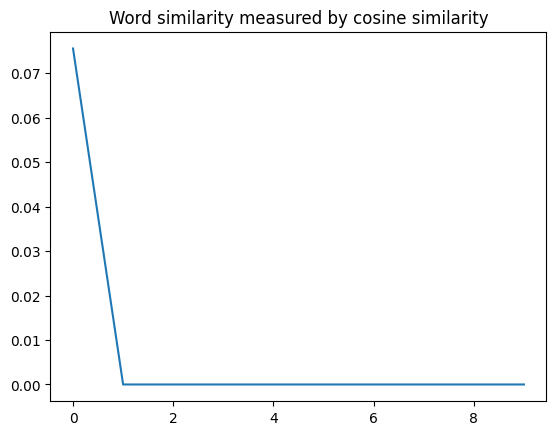

similar word to police: pyle
Top shared documents categories: ['talk.politics.guns', 'talk.politics.guns', 'rec.autos', 'misc.forsale', 'talk.politics.mideast', 'sci.electronics', 'soc.religion.christian', 'talk.religion.misc', 'comp.sys.ibm.pc.hardware', 'comp.os.ms-windows.misc']


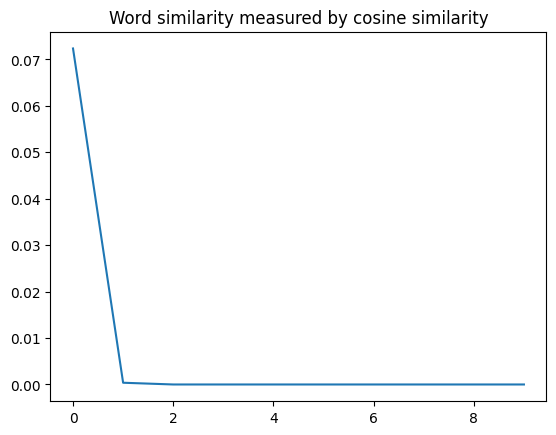

similar word to police: officer
Top shared documents categories: ['talk.politics.guns', 'talk.politics.guns', 'sci.electronics', 'talk.politics.guns', 'talk.politics.guns', 'rec.autos', 'talk.politics.guns', 'talk.politics.guns', 'rec.autos', 'sci.electronics']


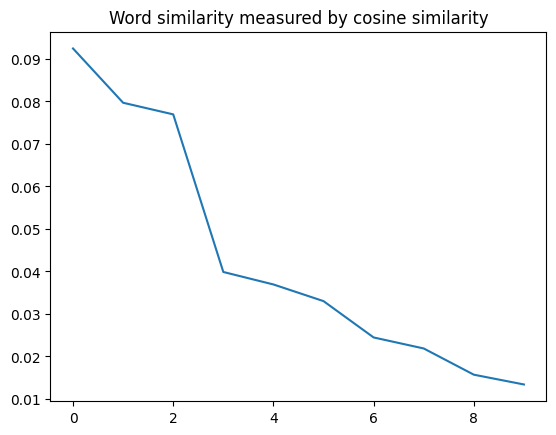

similar word to police: leroy


Top shared documents categories: ['talk.politics.guns', 'talk.politics.guns', 'rec.autos', 'misc.forsale', 'talk.politics.mideast', 'sci.electronics', 'soc.religion.christian', 'talk.religion.misc', 'comp.sys.ibm.pc.hardware', 'comp.os.ms-windows.misc']


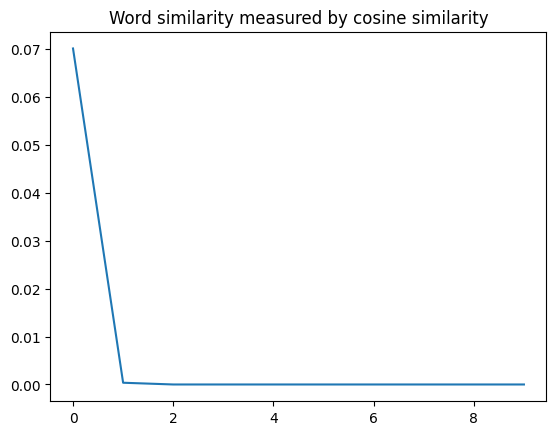

In [90]:
def analyze_similar_words(word, term_document, newsgroups_train, idx2word):
    root_word_idx = tfidfvect.vocabulary_[word]
    idx2word = {v: k for k,v in tfidfvect.vocabulary_.items()}
    similarities = cosine_similarity(term_document[root_word_idx], term_document)[0]
    top_similarities = np.argsort(similarities)[::-1][1:5]
    for idx in top_similarities:
        print(f"similar word to {idx2word[root_word_idx]}: {idx2word[idx]}")
        top_docs_idx = np.argsort(term_document[root_word_idx].multiply(term_document[idx]).toarray()[0])[::-1][:10]
        top_docs = [newsgroups_train.target_names[newsgroups_train.target[idx]] for idx in top_docs_idx]
        print(f'Top shared documents categories: {top_docs}')

        sorted_relevance = np.sort(term_document[root_word_idx].multiply(term_document[idx]).toarray()[0])[::-1]
        plot = sns.lineplot(sorted_relevance[:10])
        plot.set_title("Word similarity measured by cosine similarity")
        plt.show()

analyze_similar_words('police', term_document, newsgroups_train, idx2word)

Se ve que hay algunas palabras similares como officer y swat pero las otras 3 no son similares.

similar word to goverment: involment
Top shared documents categories: ['talk.politics.mideast', 'talk.politics.mideast', 'rec.autos', 'misc.forsale', 'talk.politics.mideast', 'sci.electronics', 'soc.religion.christian', 'talk.religion.misc', 'comp.sys.ibm.pc.hardware', 'comp.os.ms-windows.misc']


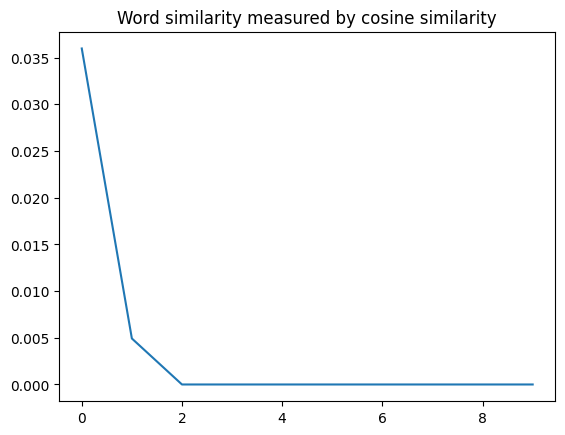

similar word to goverment: indirecly
Top shared documents categories: ['talk.politics.mideast', 'talk.politics.mideast', 'rec.autos', 'misc.forsale', 'talk.politics.mideast', 'sci.electronics', 'soc.religion.christian', 'talk.religion.misc', 'comp.sys.ibm.pc.hardware', 'comp.os.ms-windows.misc']


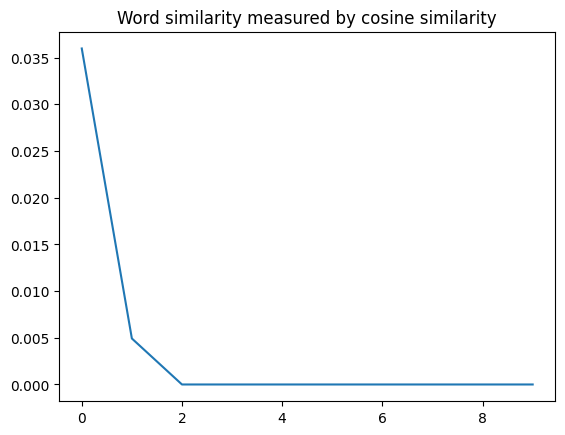

similar word to goverment: sabri
Top shared documents categories: ['talk.politics.mideast', 'rec.autos', 'talk.politics.mideast', 'sci.electronics', 'soc.religion.christian', 'talk.religion.misc', 'comp.sys.ibm.pc.hardware', 'comp.os.ms-windows.misc', 'talk.politics.misc', 'rec.sport.baseball']


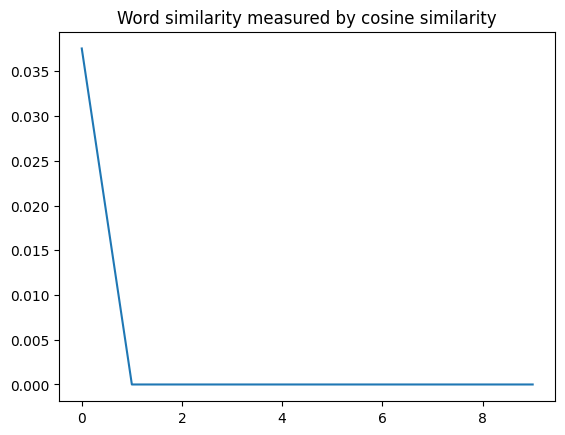

similar word to goverment: 092101
Top shared documents categories: ['talk.politics.mideast', 'rec.autos', 'talk.politics.mideast', 'sci.electronics', 'soc.religion.christian', 'talk.religion.misc', 'comp.sys.ibm.pc.hardware', 'comp.os.ms-windows.misc', 'talk.politics.misc', 'rec.sport.baseball']


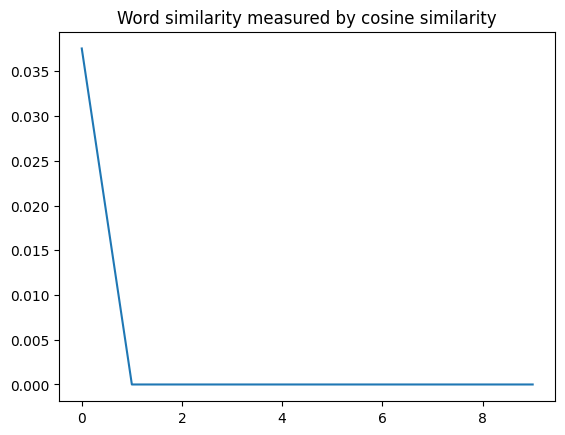

In [91]:
analyze_similar_words('goverment', term_document, newsgroups_train, idx2word)

Para goberment, que es un termino que aparece en muchos contextos, vemos que las palabras mas similares no tienen una similitud aparente.

similar word to car: cars
Top shared documents categories: ['talk.politics.misc', 'rec.autos', 'rec.autos', 'rec.autos', 'rec.autos', 'rec.autos', 'rec.autos', 'rec.sport.hockey', 'rec.autos', 'rec.autos']


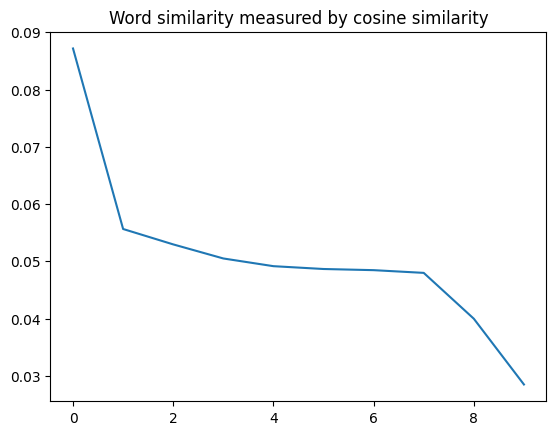

similar word to car: criterium
Top shared documents categories: ['rec.autos', 'misc.forsale', 'talk.politics.mideast', 'sci.electronics', 'soc.religion.christian', 'talk.religion.misc', 'comp.sys.ibm.pc.hardware', 'comp.os.ms-windows.misc', 'talk.politics.misc', 'rec.sport.baseball']


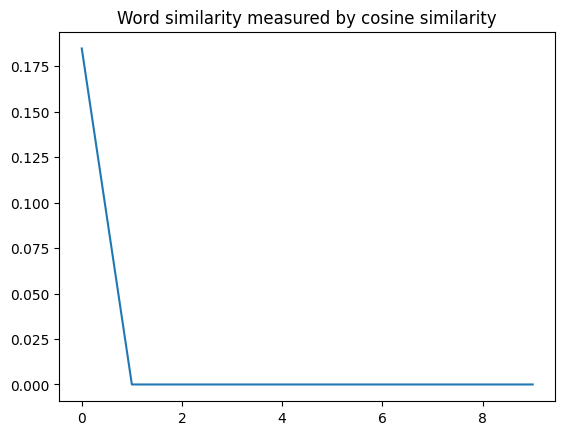

similar word to car: dealer
Top shared documents categories: ['rec.autos', 'rec.autos', 'rec.autos', 'rec.autos', 'talk.politics.misc', 'rec.autos', 'rec.autos', 'rec.autos', 'rec.autos', 'rec.autos']


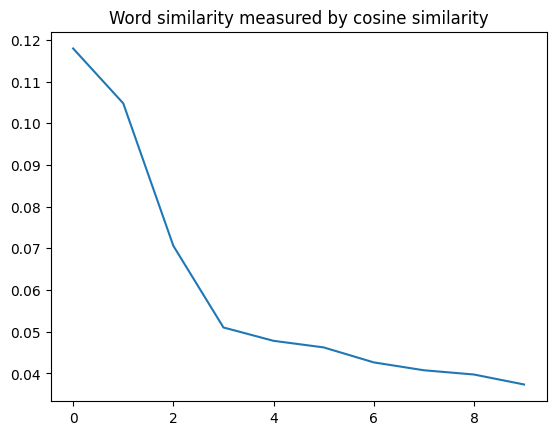

similar word to car: civic
Top shared documents categories: ['rec.autos', 'rec.autos', 'rec.autos', 'rec.autos', 'rec.autos', 'rec.autos', 'rec.autos', 'rec.autos', 'rec.autos', 'rec.autos']


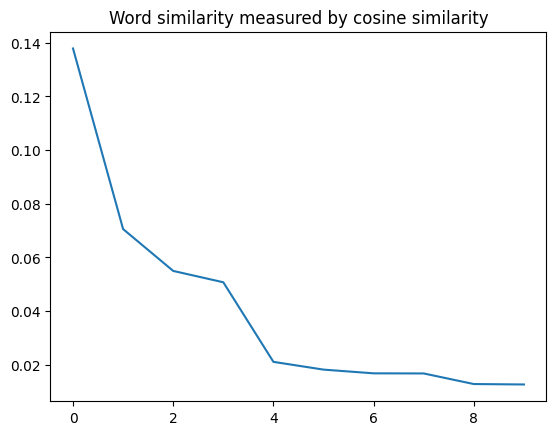

In [92]:
analyze_similar_words('car', term_document, newsgroups_train, idx2word)

En el caso de car vemos que los resultados, en general, estan relacionados y las categorias de los documentos que mas pesan suelen ser rec.autos.

similar word to jesus: christ
Top shared documents categories: ['soc.religion.christian', 'soc.religion.christian', 'talk.religion.misc', 'talk.religion.misc', 'soc.religion.christian', 'talk.religion.misc', 'talk.religion.misc', 'talk.religion.misc', 'soc.religion.christian', 'soc.religion.christian']


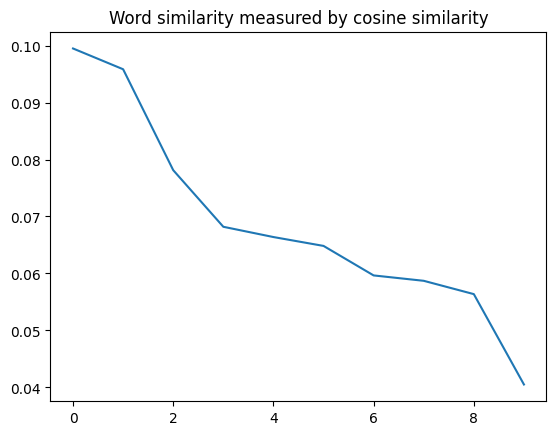

similar word to jesus: god
Top shared documents categories: ['alt.atheism', 'soc.religion.christian', 'talk.religion.misc', 'soc.religion.christian', 'talk.religion.misc', 'soc.religion.christian', 'soc.religion.christian', 'talk.religion.misc', 'soc.religion.christian', 'soc.religion.christian']


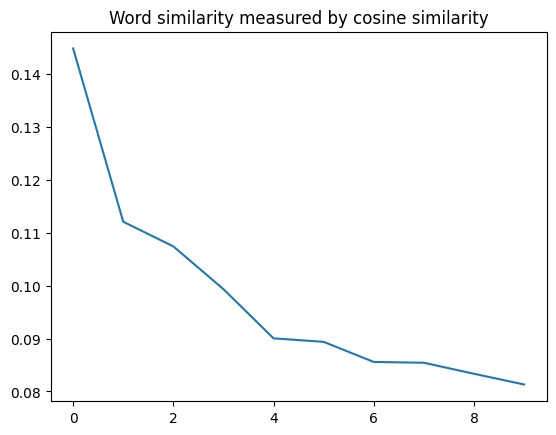

similar word to jesus: kingdom
Top shared documents categories: ['soc.religion.christian', 'soc.religion.christian', 'soc.religion.christian', 'soc.religion.christian', 'soc.religion.christian', 'talk.religion.misc', 'talk.religion.misc', 'soc.religion.christian', 'talk.religion.misc', 'soc.religion.christian']


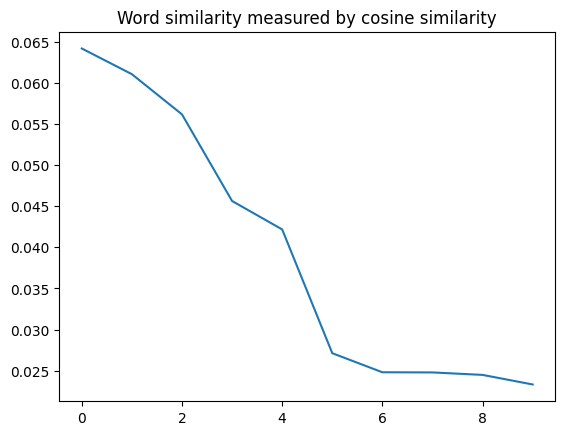

similar word to jesus: disciples


Top shared documents categories: ['soc.religion.christian', 'soc.religion.christian', 'soc.religion.christian', 'talk.religion.misc', 'soc.religion.christian', 'alt.atheism', 'talk.religion.misc', 'soc.religion.christian', 'soc.religion.christian', 'soc.religion.christian']


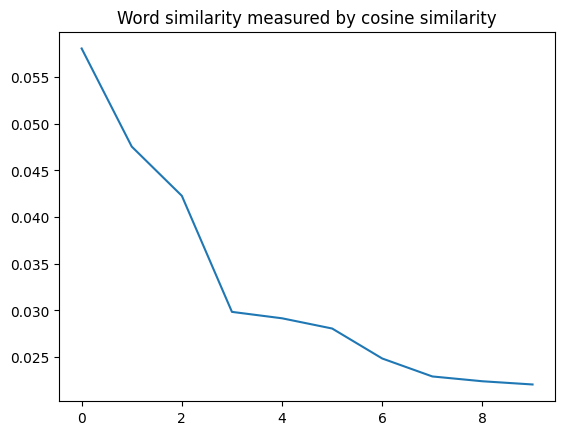

In [93]:
analyze_similar_words('jesus', term_document, newsgroups_train, idx2word)

similar word to country: borden
Top shared documents categories: ['talk.politics.misc', 'talk.politics.misc', 'talk.politics.mideast', 'sci.electronics', 'soc.religion.christian', 'talk.religion.misc', 'comp.sys.ibm.pc.hardware', 'comp.os.ms-windows.misc', 'talk.politics.misc', 'rec.sport.baseball']


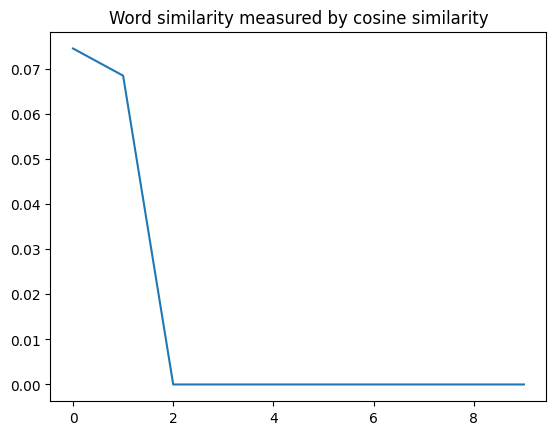

similar word to country: demagogy
Top shared documents categories: ['talk.politics.mideast', 'misc.forsale', 'talk.politics.mideast', 'sci.electronics', 'soc.religion.christian', 'talk.religion.misc', 'comp.sys.ibm.pc.hardware', 'comp.os.ms-windows.misc', 'talk.politics.misc', 'rec.sport.baseball']


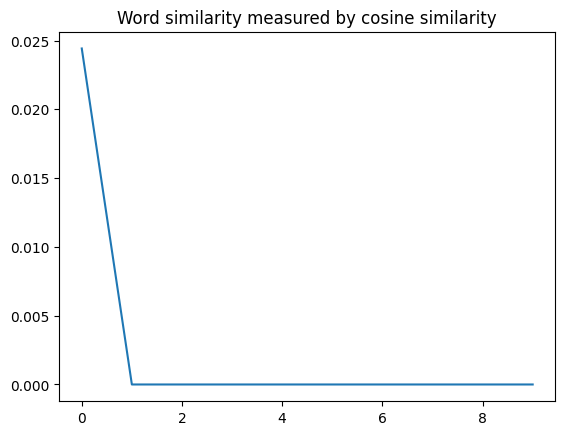

similar word to country: antisemite
Top shared documents categories: ['talk.politics.mideast', 'misc.forsale', 'talk.politics.mideast', 'sci.electronics', 'soc.religion.christian', 'talk.religion.misc', 'comp.sys.ibm.pc.hardware', 'comp.os.ms-windows.misc', 'talk.politics.misc', 'rec.sport.baseball']


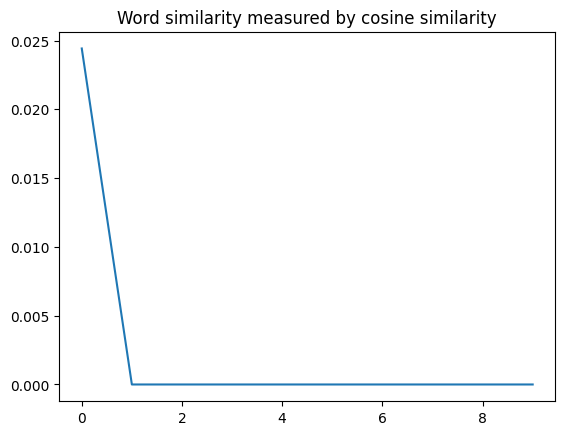

similar word to country: missusing
Top shared documents categories: ['talk.politics.mideast', 'misc.forsale', 'talk.politics.mideast', 'sci.electronics', 'soc.religion.christian', 'talk.religion.misc', 'comp.sys.ibm.pc.hardware', 'comp.os.ms-windows.misc', 'talk.politics.misc', 'rec.sport.baseball']


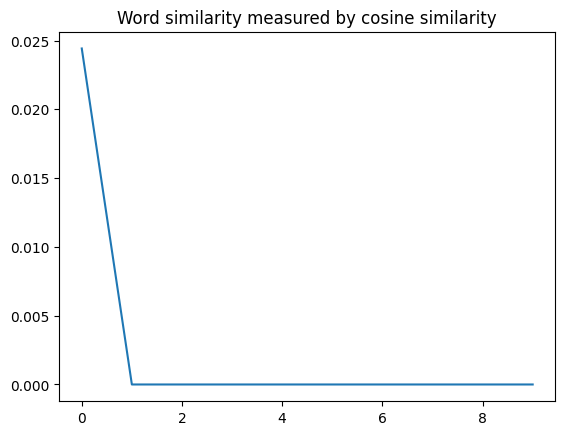

In [94]:
analyze_similar_words('country', term_document, newsgroups_train, idx2word)